## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.applications import VGG16
from keras import Model

import glob, os, random


## Data preprocessing

In [2]:
base_path = r"D:\Data\Krayen\Garbage classification\Garbage classification\Garbage classification"

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

print(len(img_list))

2527


In [3]:
for category in categories:
    directory = os.path.join(base_path, category)
    print("Images of label \"" + category + "\":\t", len(os.listdir(directory)))

Images of label "cardboard":	 403
Images of label "glass":	 501
Images of label "metal":	 410
Images of label "paper":	 594
Images of label "plastic":	 482
Images of label "trash":	 137


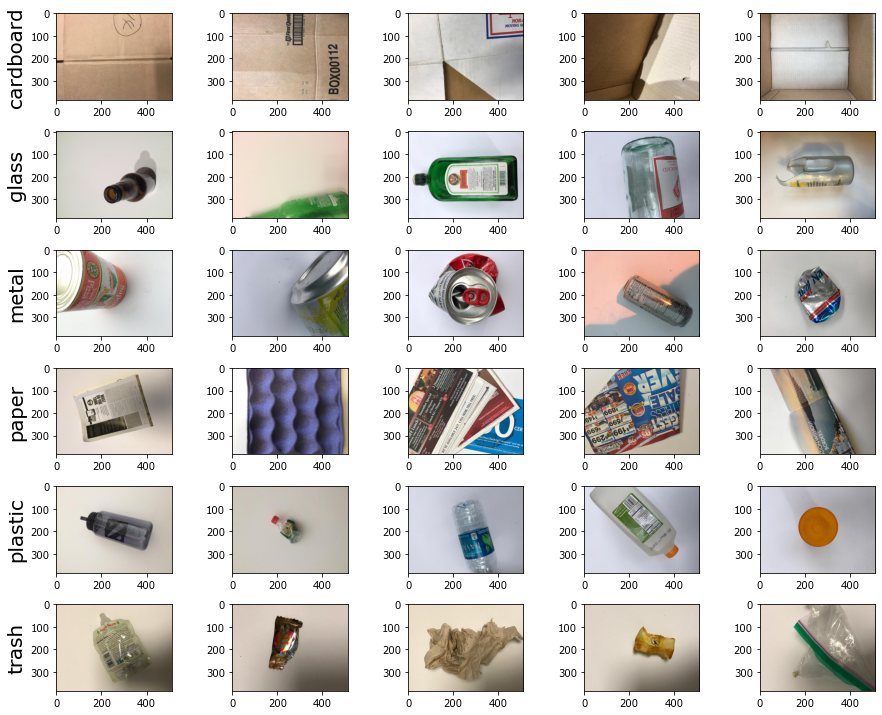

In [4]:
plt.figure(figsize = (25,10))

for i in range(6):
    directory = os.path.join(base_path, categories[i])
    for j in range(5):
        img_path = os.path.join(directory, os.listdir(directory)[j])
        img = load_img(img_path)
        
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        
        if j == 0:
            plt.ylabel(categories[i], fontsize=20)
        
plt.tight_layout()
plt.show()

## Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='categorical',
    subset='training',
    seed = 25
)

validation_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='categorical',
    subset = 'validation',
    seed = 25
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


## Model creation

In [6]:
# creating the model
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape = (150, 150, 3)),
  BatchNormalization(),
  MaxPooling2D(2, 2),
  
  Conv2D(64, (3, 3), activation='relu', padding = "same"),
  BatchNormalization(),
  MaxPooling2D(2, 2),
    
  Conv2D(64, (3, 3), activation='relu', padding = "same"),
  BatchNormalization(),
  MaxPooling2D(2, 2),
  Flatten(),
    
  Dense(128, activation = 'relu', ),
  BatchNormalization(),
  Dense(6, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                        

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 20)

### Auto adjusts our learning rate based on the monitor parameter ("validation_loss" in this case)

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.1, 
                                            min_lr = 0.00001)

In [9]:
callbacks = [earlystop, learning_rate_reduction]

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [11]:
cnn_history = model.fit(train_generator, epochs=50, shuffle = True, validation_data=validation_generator, callbacks= callbacks)

Epoch 1/50
72/72 [==============================] - 36s 483ms/step - loss: 1.4985 - categorical_accuracy: 0.4996 - val_loss: 3.7936 - val_categorical_accuracy: 0.1912 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 35s 489ms/step - loss: 1.1224 - categorical_accuracy: 0.5848 - val_loss: 3.9207 - val_categorical_accuracy: 0.1793 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 34s 473ms/step - loss: 1.0266 - categorical_accuracy: 0.6265 - val_loss: 3.0540 - val_categorical_accuracy: 0.2032 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 35s 481ms/step - loss: 0.9356 - categorical_accuracy: 0.6494 - val_loss: 2.2407 - val_categorical_accuracy: 0.2669 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 34s 472ms/step - loss: 0.8941 - categorical_accuracy: 0.6779 - val_loss: 2.1572 - val_categorical_accuracy: 0.2271 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 34s 466ms/step - loss: 0.8144 - categorical_accu

## Trying on test data

1/1 [==============================] - 0s 184ms/step


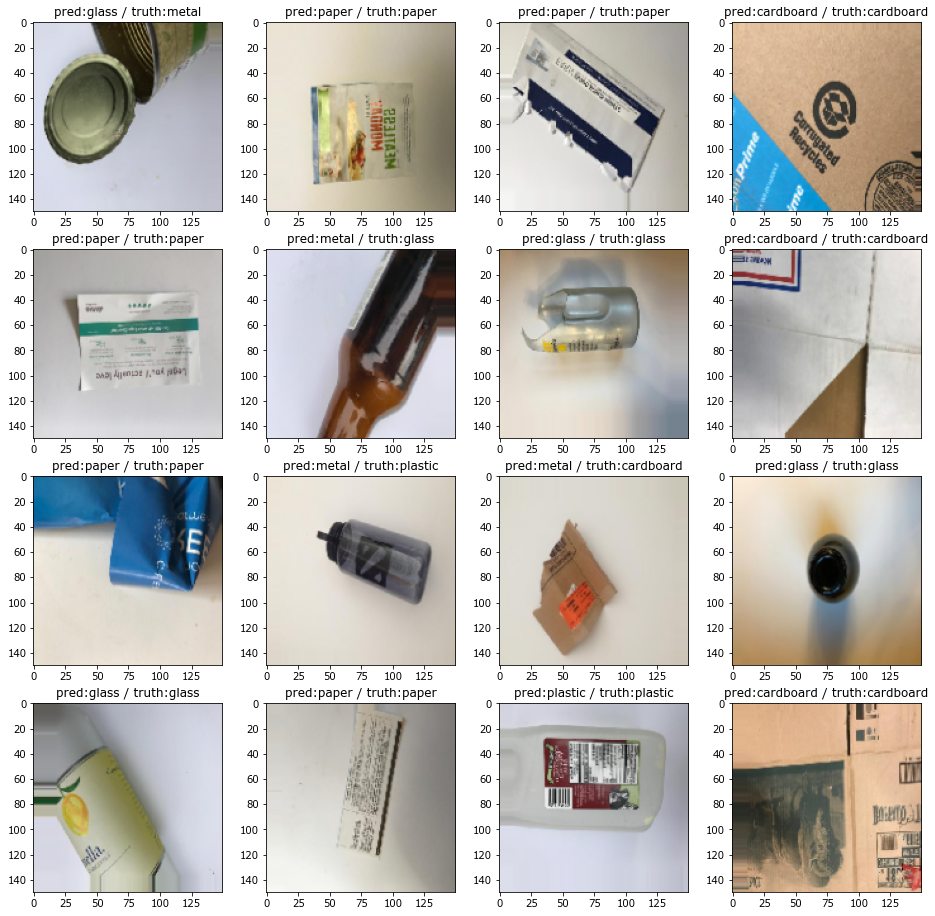

In [12]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

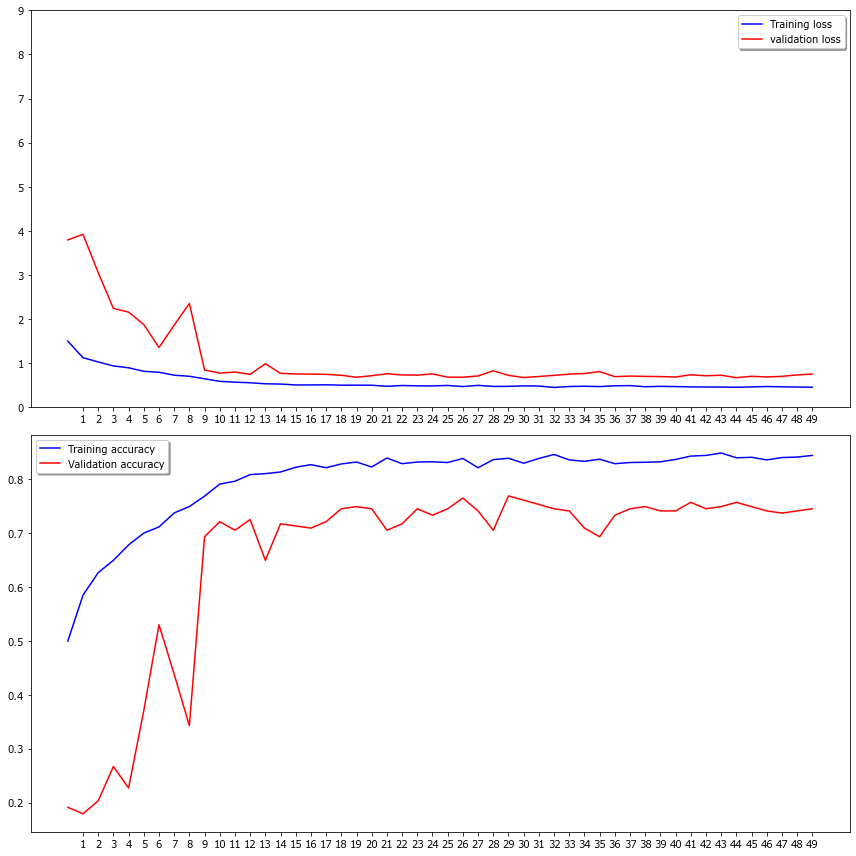

In [13]:
plt.style.use('tableau-colorblind10')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
ax1.plot(cnn_history.history['loss'], color = 'b', label = "Training loss")
ax1.plot(cnn_history.history['val_loss'], color = 'r', label = "validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 10, 1))

ax1.legend(loc = 'best', shadow = True)

ax2.plot(cnn_history.history['categorical_accuracy'], color = 'b', label = "Training accuracy")
ax2.plot(cnn_history.history['val_categorical_accuracy'], color = 'r',label = "Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

ax2.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.show()

## Using the "VGG16" model for transfer learning

In [14]:
base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

tl_model = Model(inputs=base_model.input, outputs=predictions)

base_model.trainable = False

tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
tl_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=["categorical_accuracy"])


In [16]:
tl_history = tl_model.fit(train_generator,validation_data= validation_generator,epochs=50)

Epoch 1/50
72/72 [==============================] - 100s 1s/step - loss: 1.2889 - categorical_accuracy: 0.4912 - val_loss: 1.0571 - val_categorical_accuracy: 0.5857
Epoch 2/50
72/72 [==============================] - 98s 1s/step - loss: 0.9900 - categorical_accuracy: 0.6371 - val_loss: 0.9143 - val_categorical_accuracy: 0.6494
Epoch 3/50
72/72 [==============================] - 96s 1s/step - loss: 0.8758 - categorical_accuracy: 0.6731 - val_loss: 0.8758 - val_categorical_accuracy: 0.6534
Epoch 4/50
72/72 [==============================] - 96s 1s/step - loss: 0.8301 - categorical_accuracy: 0.6946 - val_loss: 0.7710 - val_categorical_accuracy: 0.7331
Epoch 5/50
72/72 [==============================] - 97s 1s/step - loss: 0.7797 - categorical_accuracy: 0.7192 - val_loss: 0.7904 - val_categorical_accuracy: 0.7371
Epoch 6/50
72/72 [==============================] - 96s 1s/step - loss: 0.7288 - categorical_accuracy: 0.7399 - val_loss: 0.8301 - val_categorical_accuracy: 0.7131
Epoch 7/50
72/7

1/1 [==============================] - 1s 1s/step


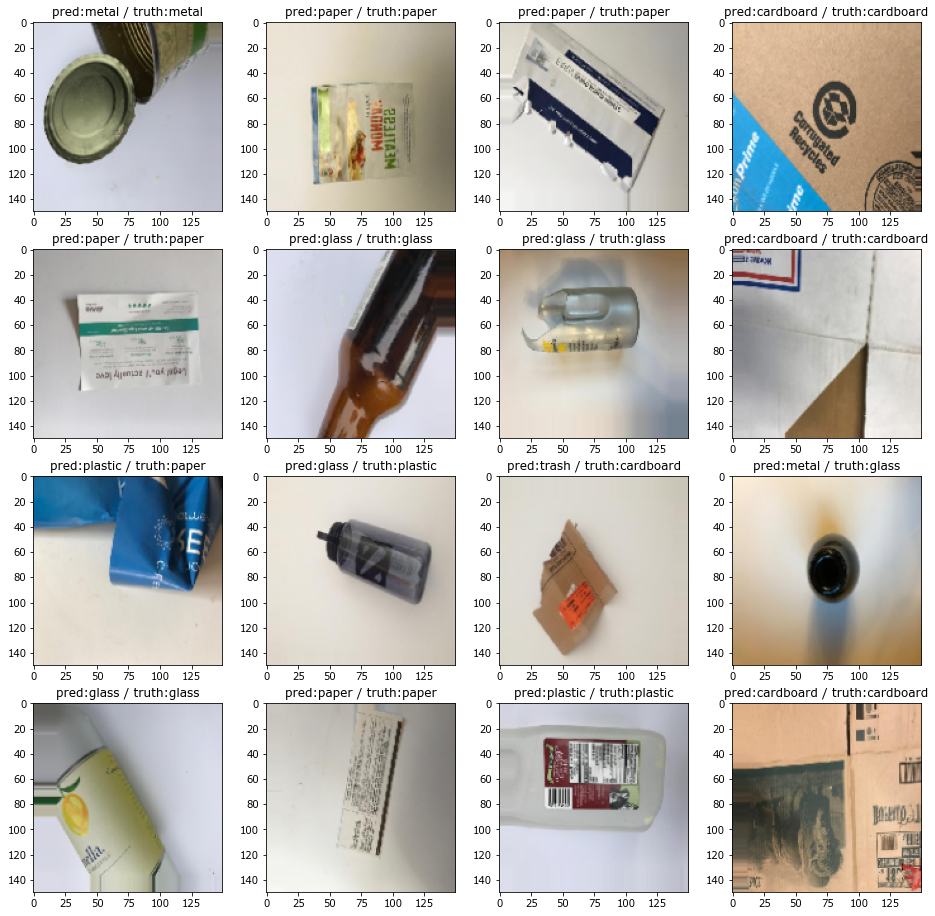

In [17]:
tl_preds = tl_model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(tl_preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

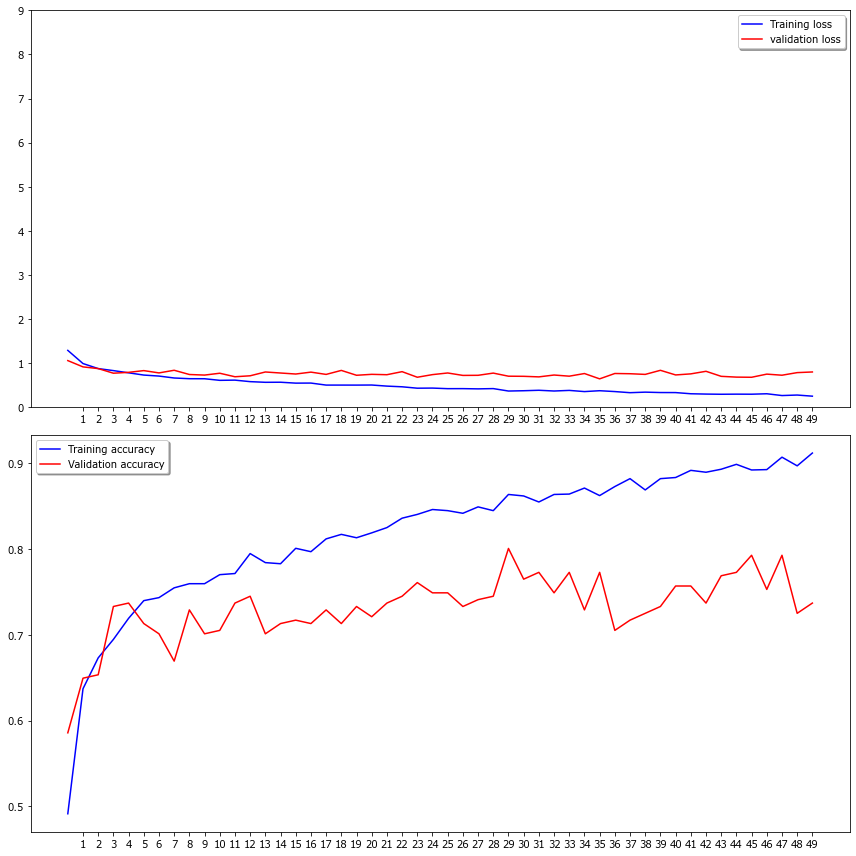

In [18]:
plt.style.use('tableau-colorblind10')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
ax1.plot(tl_history.history['loss'], color = 'b', label = "Training loss")
ax1.plot(tl_history.history['val_loss'], color = 'r', label = "validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 10, 1))

ax1.legend(loc = 'best', shadow = True)

ax2.plot(tl_history.history['categorical_accuracy'], color = 'b', label = "Training accuracy")
ax2.plot(tl_history.history['val_categorical_accuracy'], color = 'r',label = "Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

ax2.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.show()

## Comparing the two models

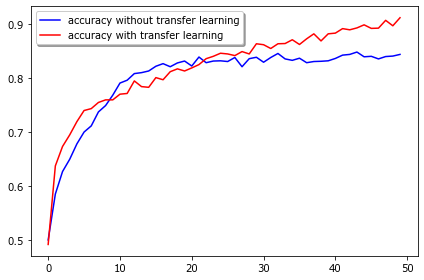

In [19]:
plt.style.use('tableau-colorblind10')



plt.plot(cnn_history.history['categorical_accuracy'], color = 'b', label = "accuracy without transfer learning")
plt.plot(tl_history.history['categorical_accuracy'], color = 'r',label = "accuracy with transfer learning")

plt.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.show()